In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

In [108]:
def base_data():
    
    ds = 'Dataset Project 1.xlsx'
    df = pd.read_excel(ds, skiprows=1)
    
    return df

In [109]:
def run_profile(dataframe, output_location):
    
    profile = ProfileReport(dataframe, title='Credit Risk DS Profiling')
    profile.to_file(output_location)
    

In [110]:
def build_correlation_matrix(df):
        
    plt.figure(figsize=(10,10))
    sns.heatmap(df.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

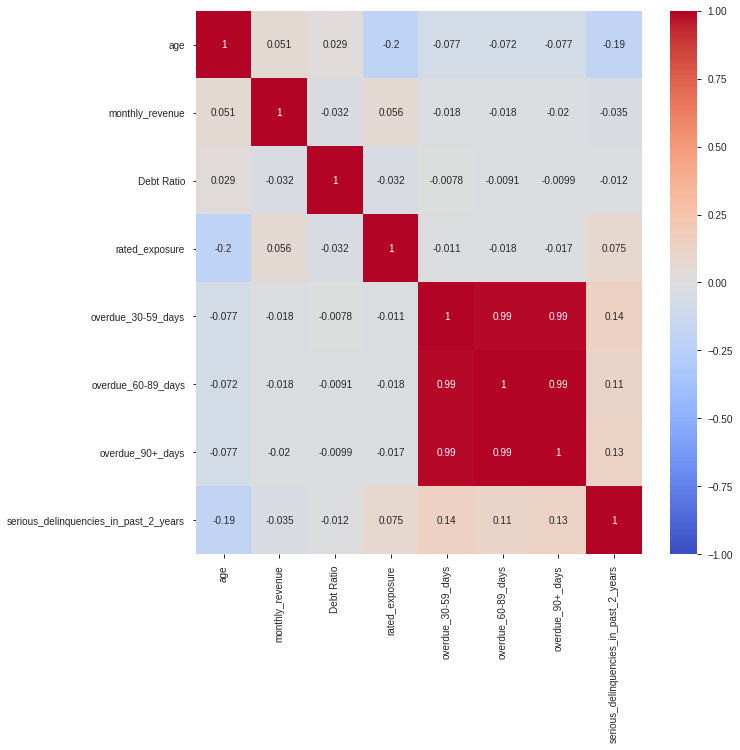

In [111]:
# Adding a Corr Matrix here for the sake of having it in the notebook
# It is in the profile as well

build_correlation_matrix(base_data())

In [112]:
def collapse_overdue(df):
    
    '''
    This method returns the maximum period the loanee was late.
    '''
    
    df['max_overdue_period'] = np.where(df['overdue_90+_days']>0, 90,
                    np.where(df['overdue_60-89_days']>0, 60,
                    np.where(df['overdue_30-59_days']>0, 30, 0)))
    
    return df

In [113]:
def overdue_composite(df):
    
    '''
    This method will produce a simple score that combines the 3
    overdue buckets (30, 60, 90). The days will be used as weights
    30x + 60y + 90z (This may need a more robust startegy)
    ''' 
    
    df['composite_overdue'] = 30*df['overdue_30-59_days'] + 60*df['overdue_60-89_days'] + 90*df['overdue_90+_days'] 
    
    # Dropping the correlated fields
    
    df = df.drop(['overdue_30-59_days', 
                  'overdue_60-89_days',
                  'overdue_90+_days'], axis=1)
    
    return df

In [114]:
def imputions(df):
    
    '''
    These had Missing warnings in the profile:
    
    Monthly_Revenue has 8643 (19.2%) missing values 
    Monthly_Revenue is highly skewed (γ1 = 90.16785868)  (medians)

    Rated_Exposure has 1117 (2.5%) missing values (means)
    
    '''
    
    df['monthly_revenue'] = df['monthly_revenue'].fillna(df['monthly_revenue'].median())
    df['rated_exposure'] = df['rated_exposure'].fillna(df['rated_exposure'].mean())
    
    return df

In [115]:
def bump_outliers(df):
    
    '''
    This method iterates over the columns and removes any rows that are 3 std devs 
    outside of the mean in either direction
    '''
    
    for col in df.columns:
        
        std_dev = df[col].std()
        mean = df[col].mean()
        
        upper_bound = mean + 3*std_dev 
        lower_bound = mean - 3*std_dev
        
        
        df = df[df[col] > lower_bound]
        df = df[df[col] < upper_bound]
        
    
    return df

In [116]:
def main():
    
    # load dataset
    df = base_data()
    
    # Initial data profiling
    run_profile(df, 'data_profiles/before_processing.html')
    
    # Processing steps
    #df = collapse_overdue(df)
    df = overdue_composite(df)
    df = imputions(df)
    df = bump_outliers(df)
    
    # Post processing profile
    run_profile(df, 'data_profiles/post_processing.html')
    
    # Write out
    df.to_csv('processed_data.csv')
    
    return df

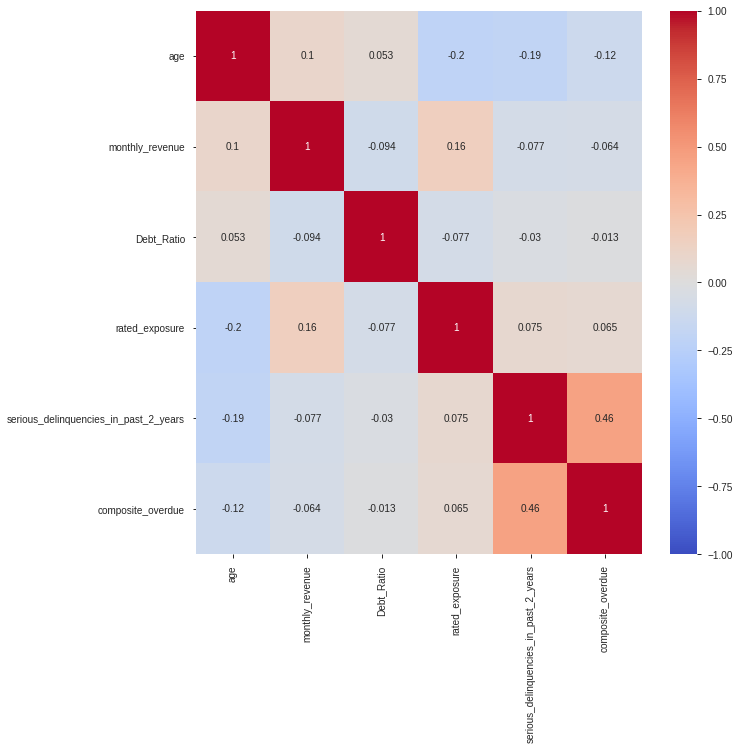

In [117]:
df = main()
build_correlation_matrix(df)